In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter

In [2]:
sim_start = pd.to_datetime('2024-09-01T00:00:00')
sim_end = pd.to_datetime('2024-09-16T00:00:00')

# Load datasets
- `groundtruth_df`: This is the ground truth historic job trace data
- `validation_df`: This is the simulation run characteristic of the many validation trials run with the simulator.
- `baseline_df`: This is the baseline simulation run used to compare against the results of Energy-Aware scheduling. This is nearly identical to `validation_df`, but the simulation parameters were altered slightly to decrease the simulation execution time.
- `ea_df`: This is the simultion results of the Energy-Aware scheduling, using the exact same simulation configuration as `baseline_df`
- `re_stats`: This provides the aggregate mean PV power availability by time of day.
- `optuna_results`: This is the results of the Optuna optimization process, providing the parameters used and the resulting RE utilization and median wait time of the simulated job trace for each trial in the study.
- `optuna_study`: This is the Optuna study object, containing data from all the trials.

In [3]:
groundtruth_df = pd.read_parquet('../data/ground_truth.parquet')
validation_df = pd.read_parquet('../data/validation_sim.parquet')
baseline_df = pd.read_parquet('../data/baseline_sim.parquet')
ea_df = pd.read_parquet('../data/ea_sim.parquet')
re_stats = pd.read_parquet('../data/re_stats.parquet')
optuna_results = pd.read_parquet('../data/optuna_results.parquet')
optuna_study = optuna.load_study(
    study_name="energy_aware_scheduling",
    storage="sqlite:///../data/optuna_study.db"
)

In [4]:
groundtruth_df

,submit,start,end,nodes,runtime,wait_time,avg_power_per_node
0,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:44,1,2 days 00:00:09,4413886.0,747.857160
1,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:44,1,2 days 00:00:09,4413886.0,751.474773
2,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:44,1,2 days 00:00:09,4413886.0,749.230023
3,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 07:41:13,1,1 days 21:40:38,4413886.0,749.883184
4,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:44,1,2 days 00:00:09,4413886.0,749.625396
...,...,...,...,...,...,...,...
161261,2024-09-15 22:44:20,2024-09-15 22:44:35,2024-09-15 22:51:12,1,0 days 00:06:37,15.0,265.277078
161262,2024-09-15 22:50:47,2024-09-15 22:50:54,2024-09-15 22:56:37,1,0 days 00:05:43,7.0,280.282799
161263,2024-09-15 22:55:52,2024-09-15 22:55:55,2024-09-15 23:10:27,1,0 days 00:14:32,3.0,423.663991
161264,2024-09-15 22:56:47,2024-09-15 22:56:55,2024-09-15 23:16:10,1,0 days 00:19:15,8.0,426.638095


In [5]:
validation_df

,submit,start,end,nodes,runtime,wait_time,avg_power_per_node
0,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,751.474773
1,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,749.815982
2,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,750.282057
3,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,747.857160
4,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,749.326447
...,...,...,...,...,...,...,...
161261,2024-09-15 22:44:20,2024-09-15 22:46:15.000,2024-09-15 22:52:52.000,1,0 days 00:06:37,115.0,265.277078
161262,2024-09-15 22:50:47,2024-09-15 22:52:52.000,2024-09-15 22:58:35.000,1,0 days 00:05:43,125.0,280.282799
161263,2024-09-15 22:55:52,2024-09-15 22:56:01.000,2024-09-15 23:10:33.000,1,0 days 00:14:32,9.0,423.663991
161264,2024-09-15 22:56:47,2024-09-15 22:57:01.000,2024-09-15 23:16:16.000,1,0 days 00:19:15,14.0,426.638095


In [6]:
baseline_df

,submit,start,end,nodes,runtime,wait_time,avg_power_per_node
0,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,747.857160
1,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,751.474773
2,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,749.230023
3,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 07:41:12.000,1,1 days 21:40:37,4413886.0,749.883184
4,2024-07-10 07:55:49,2024-08-30 10:00:35.000,2024-09-01 10:00:43.000,1,2 days 00:00:08,4413886.0,749.625396
...,...,...,...,...,...,...,...
161261,2024-09-15 22:44:20,2024-09-15 22:46:42.500,2024-09-15 22:53:19.500,1,0 days 00:06:37,142.5,265.277078
161262,2024-09-15 22:50:47,2024-09-15 22:53:19.500,2024-09-15 22:59:02.500,1,0 days 00:05:43,152.5,280.282799
161263,2024-09-15 22:55:52,2024-09-15 22:56:01.000,2024-09-15 23:10:33.000,1,0 days 00:14:32,9.0,423.663991
161264,2024-09-15 22:56:47,2024-09-15 22:57:01.000,2024-09-15 23:16:16.000,1,0 days 00:19:15,14.0,426.638095


In [7]:
ea_df

,submit,start,end,nodes,runtime,wait_time,avg_power_per_node
0,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 07:41:12,1,1 days 21:40:37,4413886.0,749.883184
1,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:43,1,2 days 00:00:08,4413886.0,750.131110
2,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:43,1,2 days 00:00:08,4413886.0,747.857160
3,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:43,1,2 days 00:00:08,4413886.0,751.037602
4,2024-07-10 07:55:49,2024-08-30 10:00:35,2024-09-01 10:00:43,1,2 days 00:00:08,4413886.0,749.815982
...,...,...,...,...,...,...,...
161261,2024-09-15 22:44:20,2024-09-15 22:44:29,2024-09-15 22:51:06,1,0 days 00:06:37,9.0,265.277078
161262,2024-09-15 22:50:47,2024-09-15 22:51:01,2024-09-15 22:56:44,1,0 days 00:05:43,14.0,280.282799
161263,2024-09-15 22:55:52,2024-09-15 22:56:01,2024-09-15 23:10:33,1,0 days 00:14:32,9.0,423.663991
161264,2024-09-15 22:56:47,2024-09-15 22:56:49,2024-09-15 23:16:04,1,0 days 00:19:15,2.0,426.638095


In [8]:
re_stats

,mean,bin_mid
0,0.0,0.5
1,0.0,1.5
2,0.0,2.5
3,0.0,3.5
4,0.0,4.5
...,...,...
1435,0.0,1435.5
1436,0.0,1436.5
1437,0.0,1437.5
1438,0.0,1438.5


In [9]:
optuna_results

,alpha,beta,gamma,start,end,median_wait_time,re_utilization
0,1.0194,1.7136,0.4288,10.3121,11.0391,2.332361,0.230494
1,0.8619,4.7611,0.3032,8.0195,9.0604,2.200972,0.232046
2,0.7965,5.6730,0.2766,7.7656,9.6840,2.813472,0.232112
3,0.9622,4.9364,0.3490,7.5496,9.4336,2.779861,0.232168
4,0.5787,5.7228,0.2777,7.3658,8.9793,2.751806,0.231171
...,...,...,...,...,...,...,...
495,0.3552,4.9026,0.3747,6.4956,9.6370,2.872639,0.231539
496,1.0014,2.2695,0.1140,6.5301,10.0102,4.794583,0.231618
497,0.8099,4.8909,0.4454,6.7930,9.4062,2.315000,0.231848
498,0.9040,5.0333,0.3597,9.4231,9.8688,1.873750,0.229753


# Validate Sim vs Ground Truth

## Figure 7a

In [10]:
def compute_power_timeseries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute a time-indexed power allocation timeseries from job-level power usage data.

    This function calculates the total allocated power over time based on job start and end events.
    It returns a DataFrame indexed by time (resampled at 1-second resolution), including the 
    total allocated power and the time of day (in minutes) for each timestamp.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing the following columns:
        - 'start': job start times (datetime)
        - 'end': job end times (datetime)
        - 'nodes': number of nodes allocated per job
        - 'avg_power_per_node': average power per node for each job

    Returns
    -------
    pd.DataFrame
        DataFrame indexed by time (at 1-second intervals), containing:
        - 'allocated_power': total power allocated at each second
        - 'time': timestamp (same as index)
        - 'time_of_day': time of day in minutes (0 to 1440)
    """
    # Build event-based power changes
    power_changes = pd.concat([
        pd.DataFrame({
            'time': df['start'], 
            'power_change': df['avg_power_per_node'] * df['nodes']
        }),
        pd.DataFrame({
            'time': df['end'], 
            'power_change': -df['avg_power_per_node'] * df['nodes']
        })
    ])
    power_changes = power_changes.sort_values('time')

    # Compute cumulative allocated power over time
    power_changes['allocated_power'] = power_changes['power_change'].cumsum()
    power_changes.set_index('time', inplace=True)

    # Remove duplicate timestamps (keep last), resample at 1-second intervals
    power_changes = power_changes[~power_changes.index.duplicated(keep='last')]
    power_changes = power_changes['allocated_power'].resample('1s').ffill()

    # Build final DataFrame with time and time-of-day features
    power_df = pd.DataFrame(power_changes)
    power_df['time'] = power_df.index
    power_df = power_df[power_df.time.between(sim_start, sim_end)]
    power_df['time_of_day'] = power_df['time'].dt.hour * 60 + power_df['time'].dt.minute

    return power_df

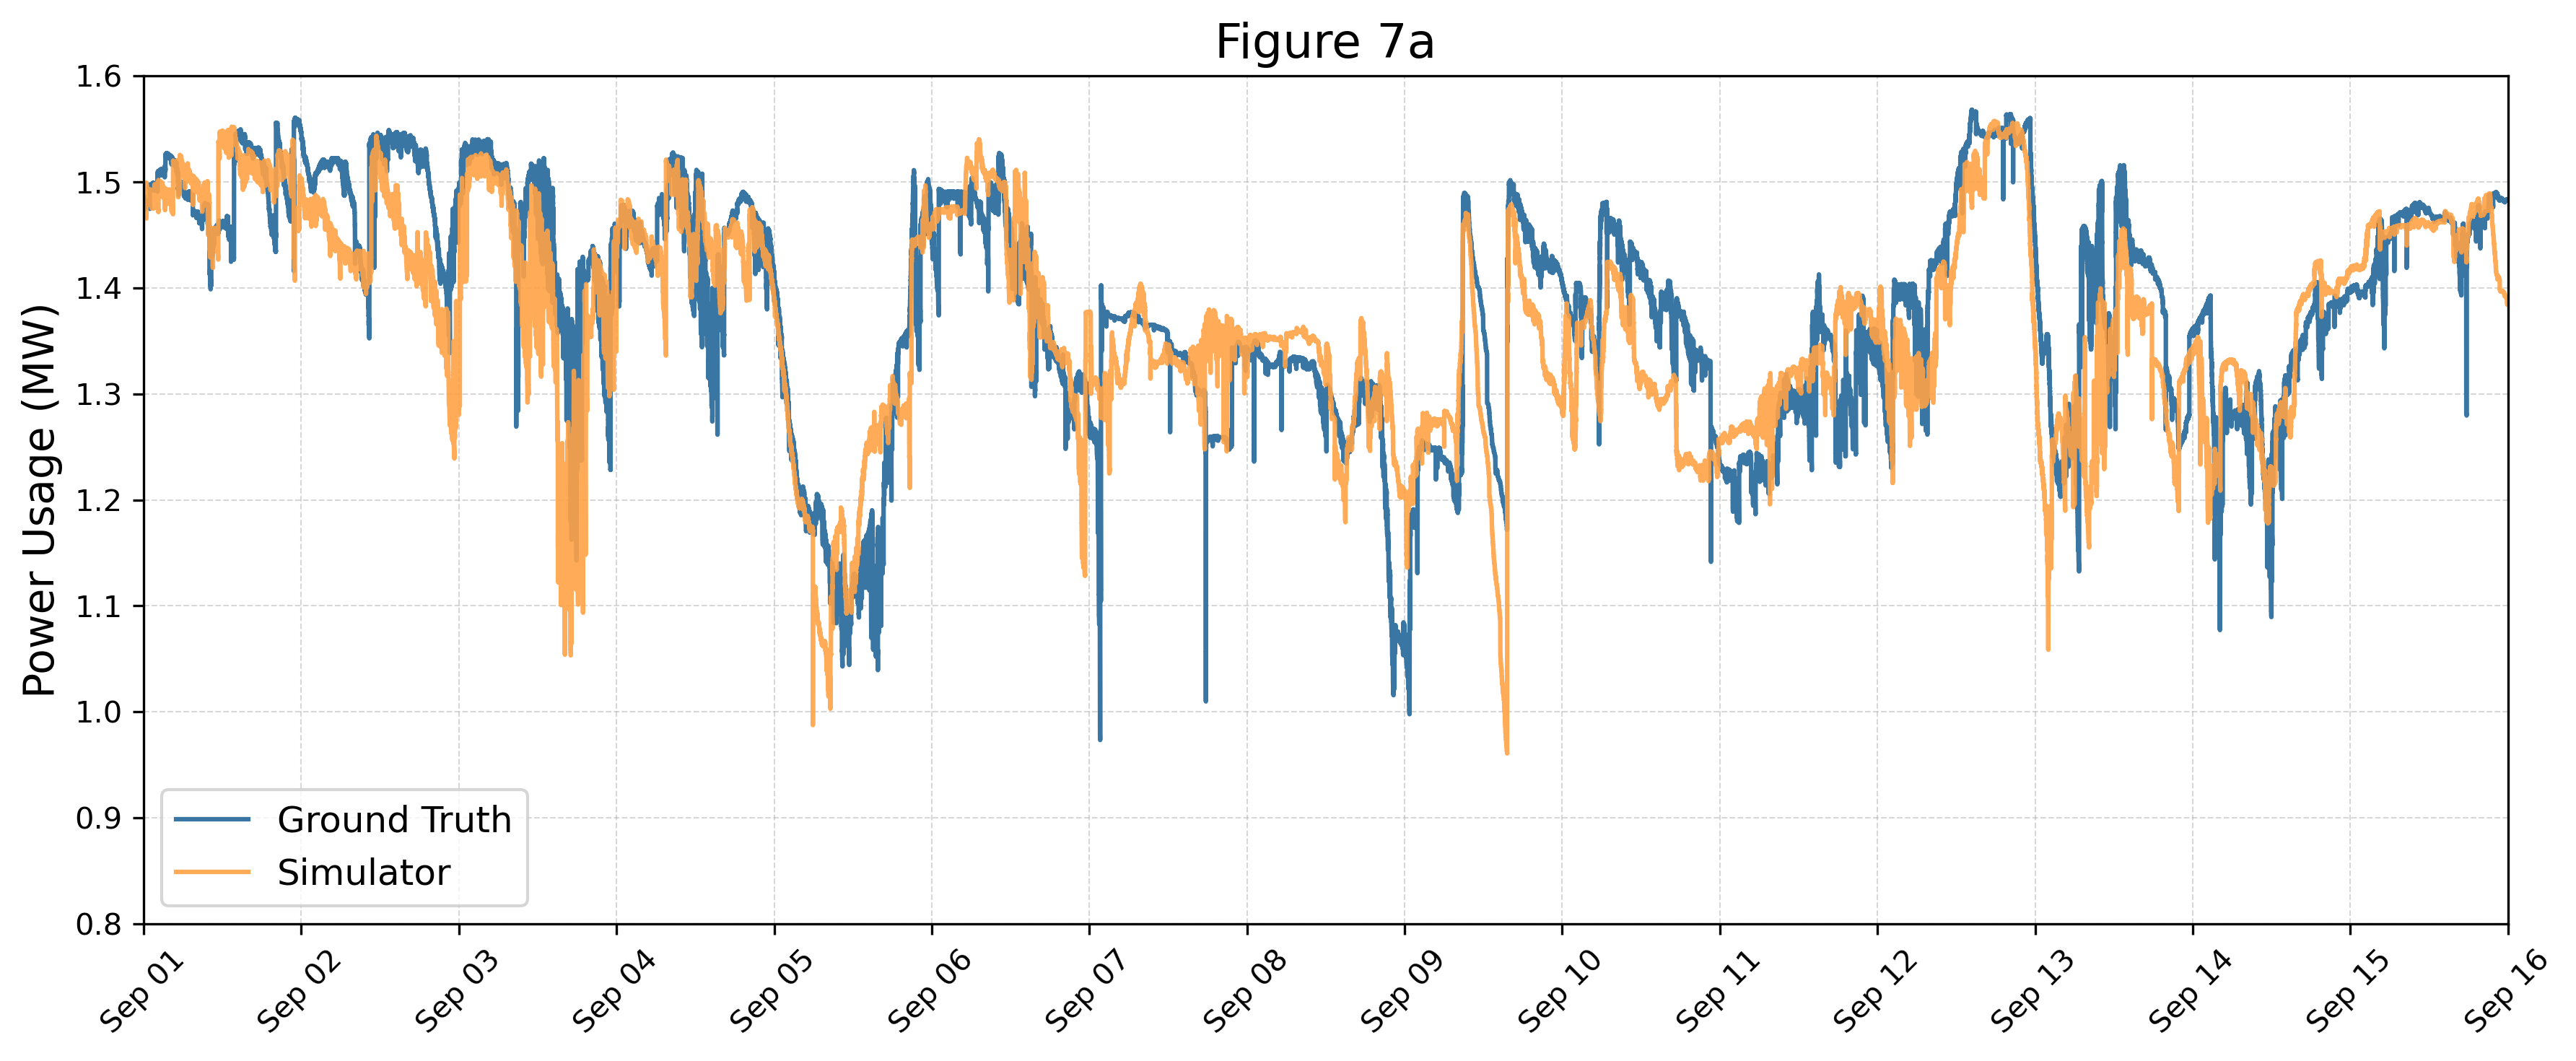

In [11]:
# Ground truth: build event timeline of node power changes
power_changes = compute_power_timeseries(groundtruth_df)

# Simulation: same logic applied to validation data
power_changes_sim = compute_power_timeseries(validation_df)

plt.figure(figsize=(12, 5), dpi=300)

# Title and labels
plt.title('Figure 7a', fontsize=16)
plt.ylabel('Power Usage (MW)', fontsize=14)

plt.plot(
    power_changes.index,
    power_changes.allocated_power / 1e6,
    linewidth=1.5,
    label='Ground Truth',
    color='#3976A3'
)

plt.plot(
    power_changes_sim.index,
    power_changes_sim.allocated_power / 1e6,
    linewidth=1.5,
    alpha=.9,
    label='Simulator',
    color='#FFA245'  # Amber Pop!
)

plt.xlim([sim_start, sim_end])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

plt.xlim([sim_start, sim_end])
plt.ylim([.8,1.6])
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

## Figure 7b: Wait Time Timeseries

In [12]:
def compute_wait_event_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the time-varying average waiting time for events based on submission and start times.

    This function expands each record in the input DataFrame by the number of nodes specified
    (i.e., duplicates each row `nodes` times), then constructs an "event timeline" of arrivals
    (submissions) and departures (starts). It computes the cumulative count of active events and
    cumulative sum of their submission times at each unique time point, and uses these to calculate
    the average waiting time at each time in hours. This amounts to weighting each job by the number
    of nodes used, which helps to paint a more accurate picture of wait time, giving the final result
    of the average wait time per node requested.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing at least the following columns:
        - 'nodes': int or array-like of ints, number of nodes used by the job.
        - 'submit': Submission timestamps of events.
        - 'start': Start timestamps of events.

    Returns
    -------
    event_df : pandas.DataFrame
        A DataFrame with the following columns:
        - 'time': float, unique time points (in hours since epoch) at which events occur.
        - 'avg_wait': float, the average waiting time (in hours) of all active events just after that time.

    Notes
    -----
    1. Time units are converted from nanoseconds to hours by dividing by 1e9 and then by 3600.
    2. For each submission (arrival) event, `delta_count` is +1 and `delta_sum` is +submission_time.
    3. For each start (departure) event, `delta_count` is -1 and `delta_sum` is -submission_time.
    4. Events are sorted by time; for ties, departures (order=0) are processed before arrivals (order=1).
    5. The algorithm computes running sums:
       - cum_count: number of active events at each step
       - cum_sum: total of submission times for active events at each step
    6. The average waiting time at time t is computed as
       avg_wait = t - (cum_sum / cum_count), unless cum_count is zero (then NaN).
    """
    # Expand each row by its 'nodes' count
    new_rows = []
    for _, row in df.iterrows():
        for _ in range(int(row['nodes'])):
            new_rows.append(row.to_dict())
    new_df = pd.DataFrame(new_rows).reset_index(drop=True)

    # Construct arrival and departure event DataFrames
    # Convert timestamps to hours since epoch
    time_hours = lambda x: x.astype(int) / 1e9 / 3600
    arrivals = pd.DataFrame({
        'time': time_hours(new_df['submit']),
        'delta_count': 1,
        'delta_sum': time_hours(new_df['submit']),
        'order': 1
    })
    departures = pd.DataFrame({
        'time': time_hours(new_df['start']),
        'delta_count': -1,
        'delta_sum': -time_hours(new_df['submit']),
        'order': 0
    })

    # Merge and sort events
    events = pd.concat([arrivals, departures], ignore_index=True)
    events.sort_values(by=['time', 'order'], inplace=True)
    events.reset_index(drop=True, inplace=True)

    # Compute running totals
    events['cum_count'] = events['delta_count'].cumsum()
    events['cum_sum'] = events['delta_sum'].cumsum()

    # Identify unique time points and group slices
    times = events['time'].values
    unique_times, first_idx, counts = np.unique(times, return_index=True, return_counts=True)

    avg_wait_list = []
    prev_count = 0.0
    prev_sum = 0.0
    orders = events['order'].values
    cum_counts = events['cum_count'].values
    cum_sums = events['cum_sum'].values

    # Calculate average wait for each unique time
    for t, idx, cnt in zip(unique_times, first_idx, counts):
        group_ord = orders[idx:idx+cnt]
        group_counts = cum_counts[idx:idx+cnt]
        group_sums = cum_sums[idx:idx+cnt]

        if group_ord[0] == 0:
            # If departures come first at this time point
            num_dep = (group_ord == 0).sum()
            curr_count = group_counts[num_dep - 1]
            curr_sum = group_sums[num_dep - 1]
        else:
            curr_count = prev_count
            curr_sum = prev_sum

        if curr_count > 0:
            avg_wait = t - (curr_sum / curr_count)
        else:
            avg_wait = np.nan
        avg_wait_list.append(avg_wait)

        prev_count = group_counts[-1]
        prev_sum = group_sums[-1]

    # Build result DataFrame
    event_df = pd.DataFrame({
        'time': unique_times,
        'avg_wait': avg_wait_list
    })
    return event_df

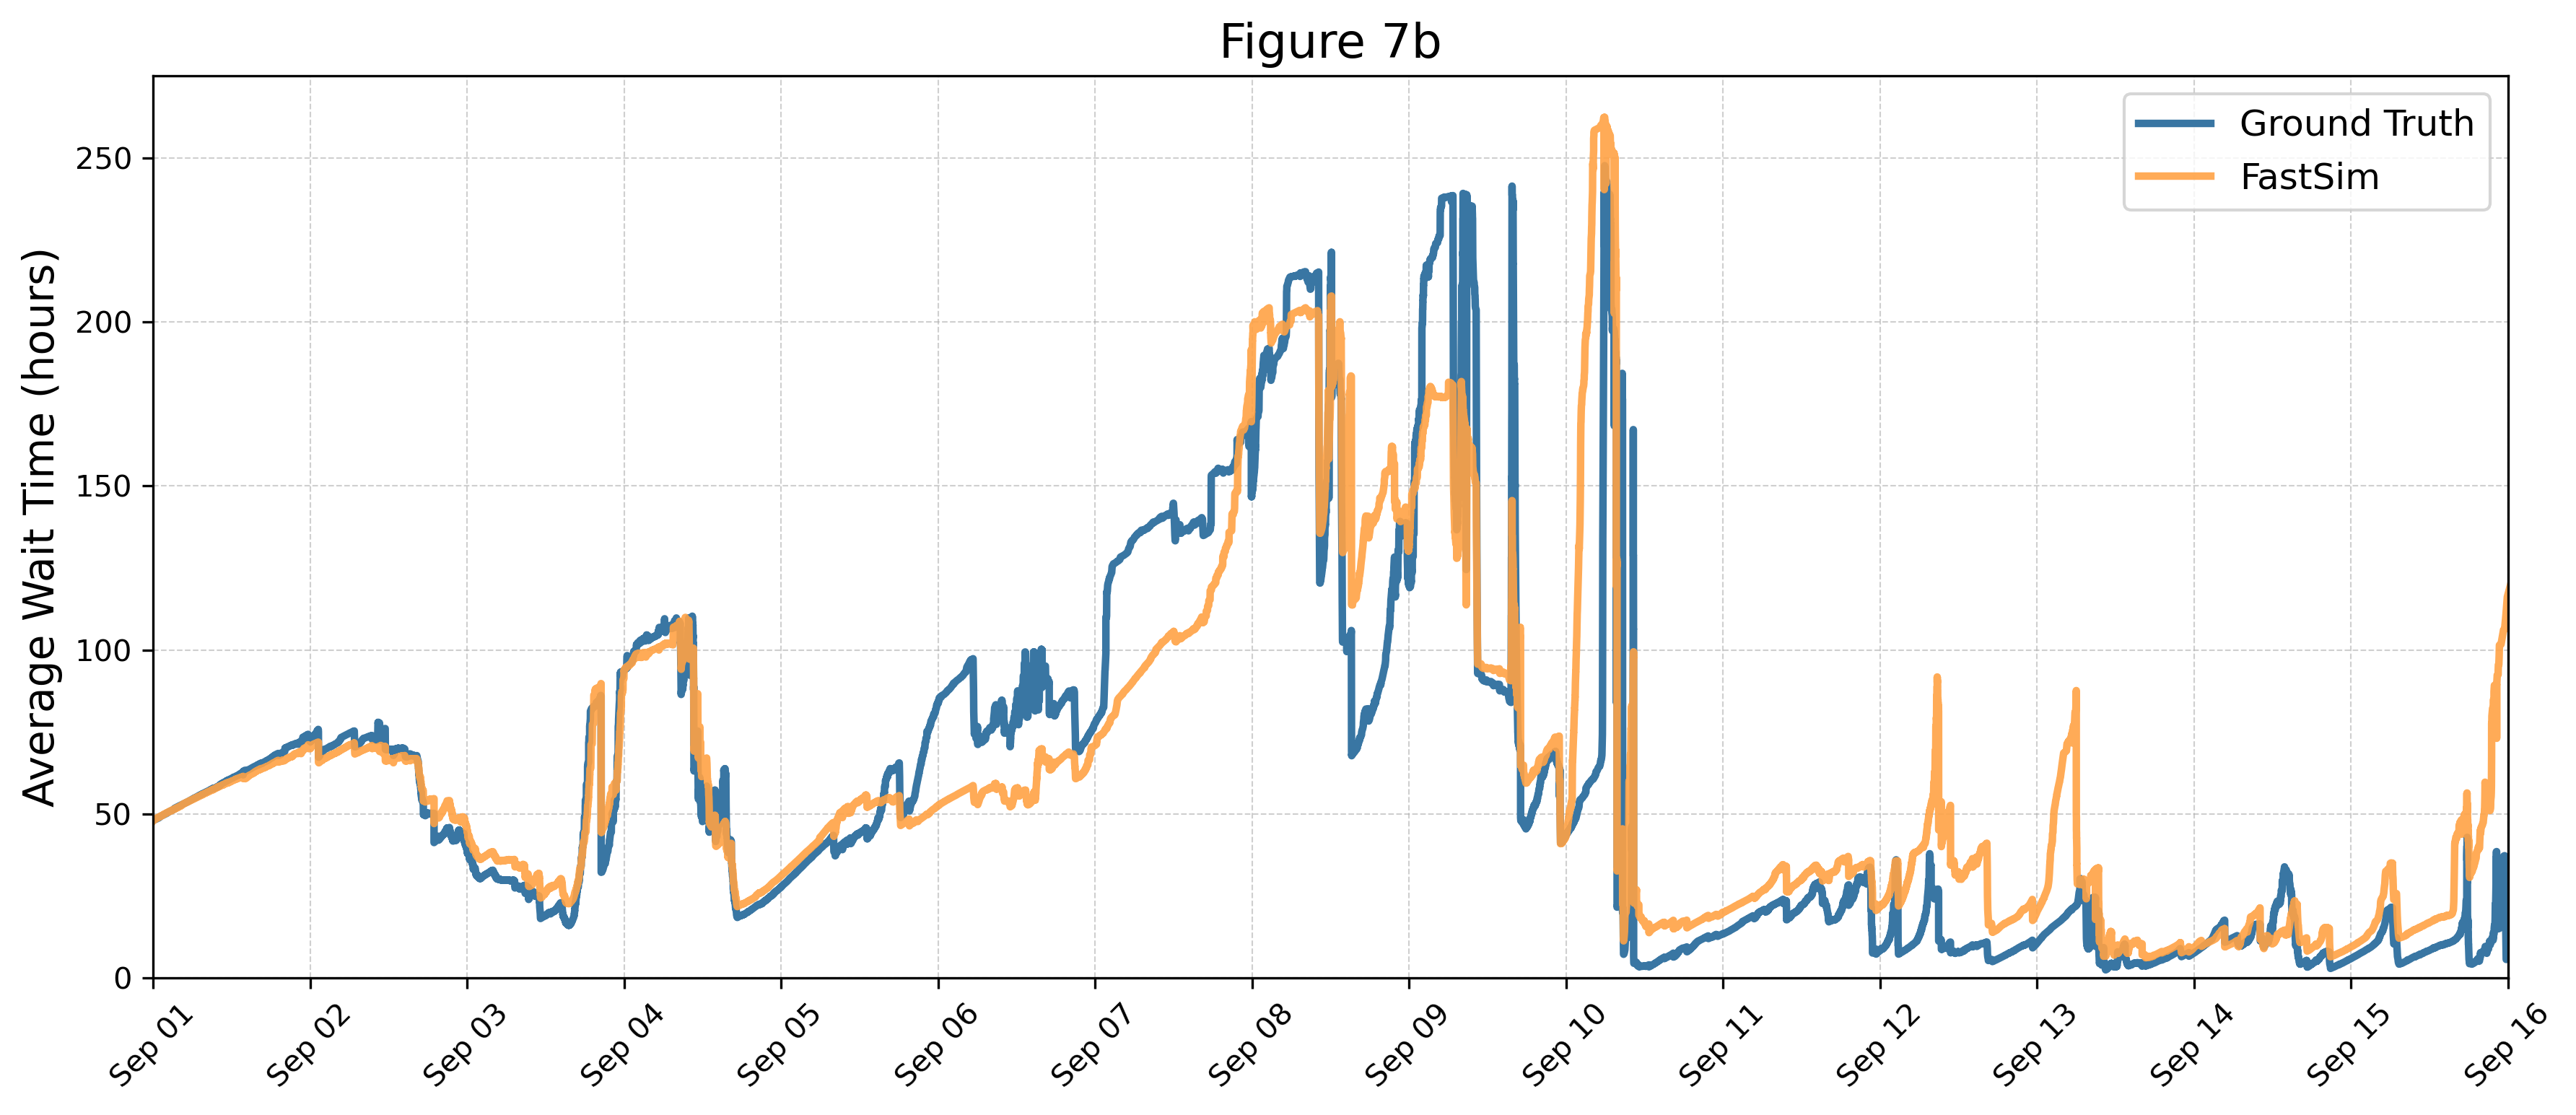

In [13]:
sim_event_df = compute_wait_event_df(validation_df)
true_event_df = compute_wait_event_df(groundtruth_df)

plt.figure(figsize=(12, 5), dpi=300)

# Plot Ground Truth and Simulation
plt.plot(
    pd.to_datetime(true_event_df.time * 3600 * 1e9),
    true_event_df.avg_wait,
    label='Ground Truth',
    color='#3976A3',
    linewidth=2.5,
)
plt.plot(
    pd.to_datetime(sim_event_df.time * 3600 * 1e9),
    sim_event_df.avg_wait,
    label='FastSim',
    color='#FFA245',
    linewidth=2.5,
    alpha=0.9
)

# X-axis formatting
plt.xlim([sim_start, sim_end])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

# Y-axis
plt.ylabel('Average Wait Time (hours)', fontsize=14)
plt.ylim([0,275])  # Ensure y starts at 0 for visual grounding

# Grid, legend, and styling
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.title('Figure 7b', fontsize=16)
plt.show()

## Figure 7c: Wait Time Distribution

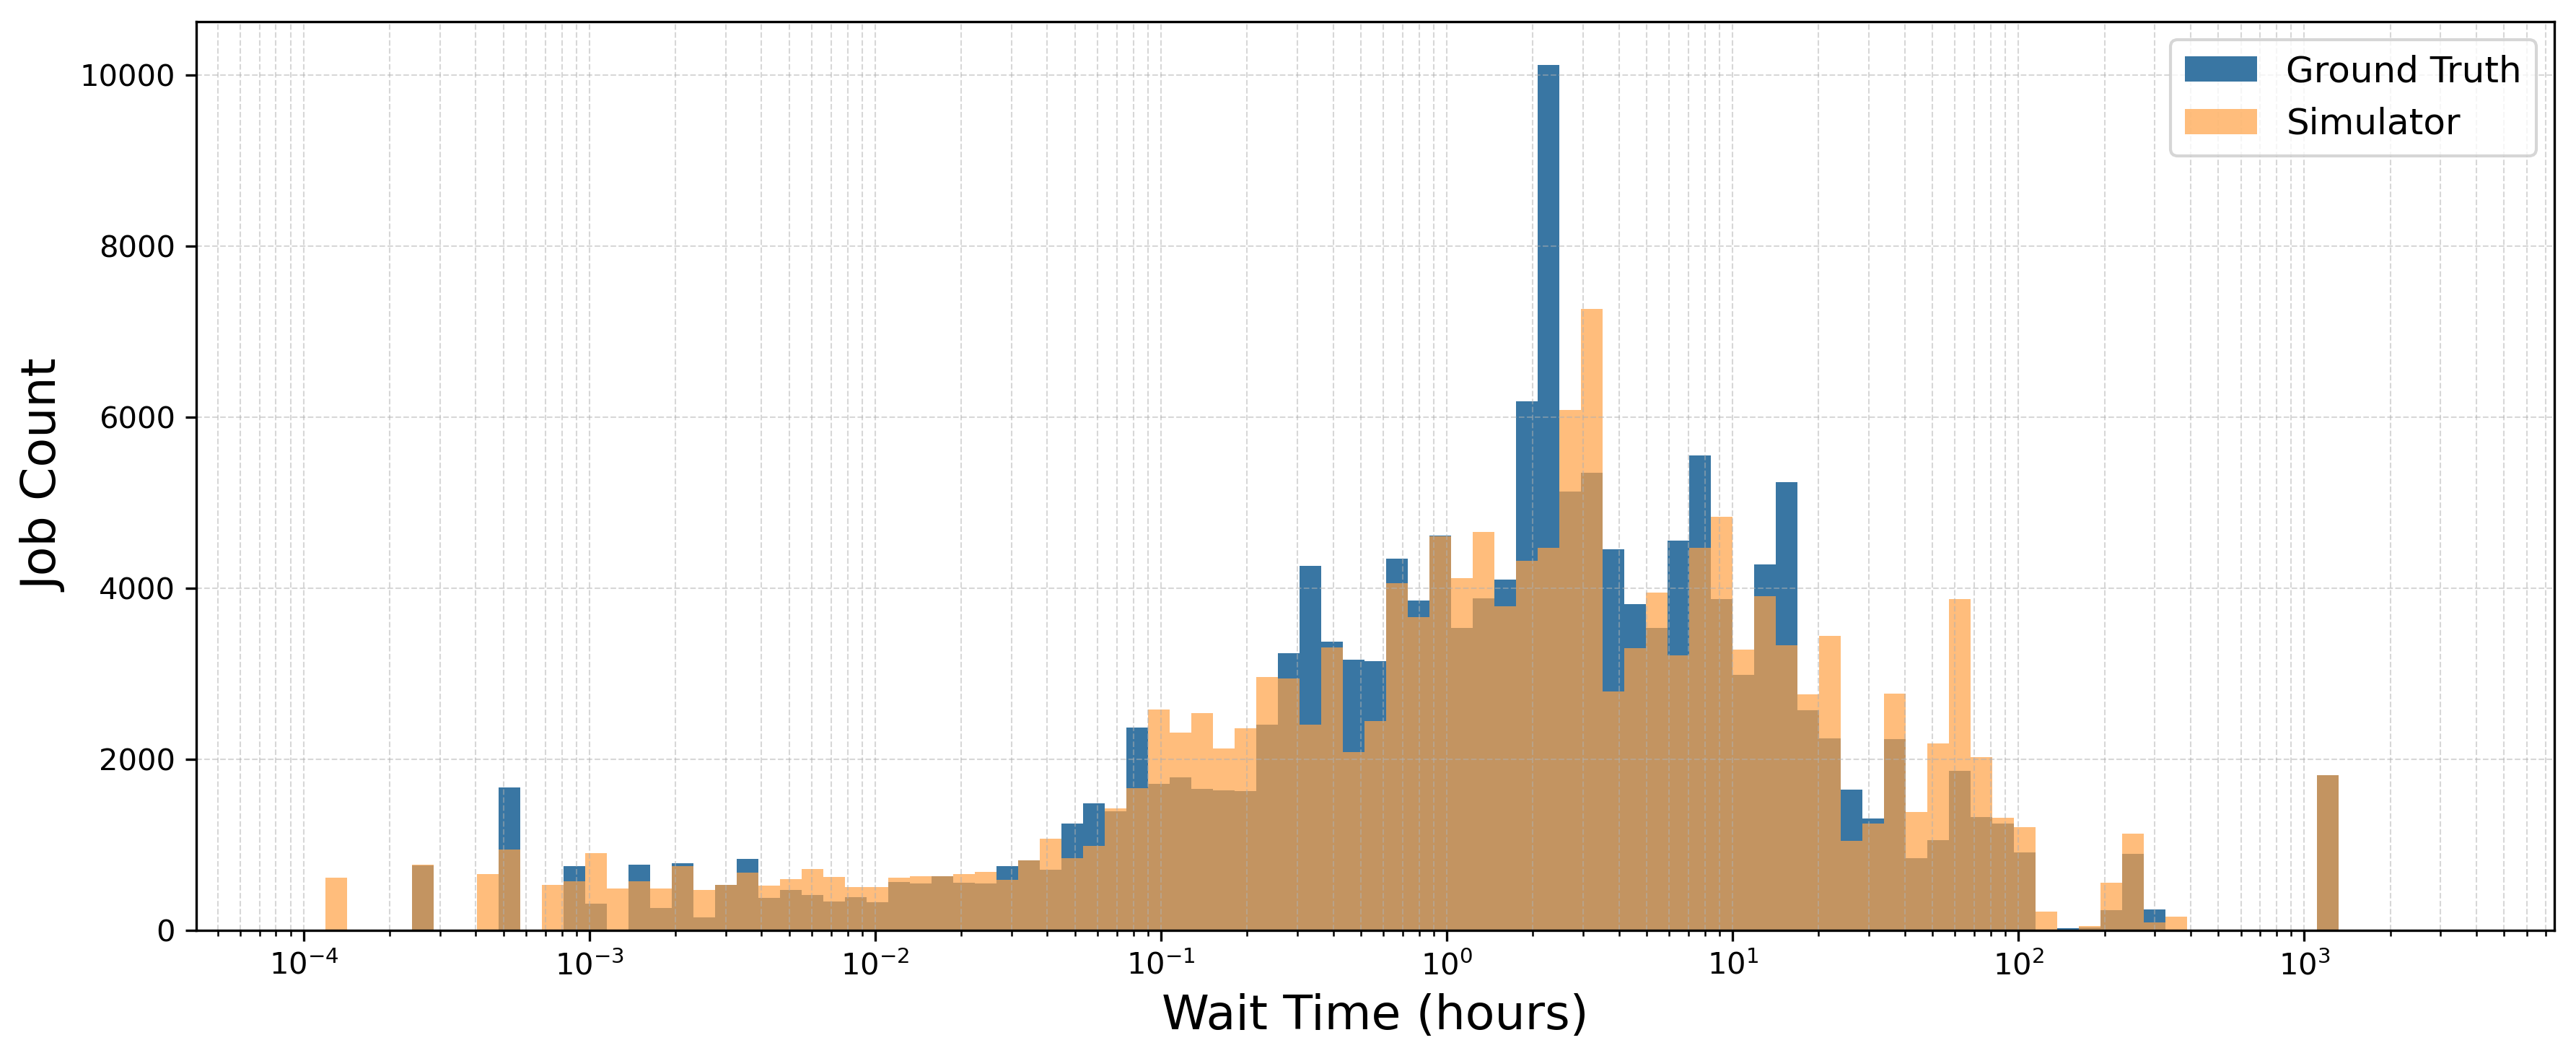

In [14]:
plt.figure(figsize=(12,5), dpi=300)

# Plot histograms
(groundtruth_df['wait_time'] / 3600).hist(
    bins=np.logspace(-4, 3.5, 100),
    grid=False,
    label='Ground Truth',
    color='#3976A3'
)

(validation_df['wait_time'] / 3600).hist(
    bins=np.logspace(-4, 3.5, 100),
    grid=False,
    alpha=0.7,
    label='Simulator',
    color='#FFA245'  # Amber Pop!
)

# Formatting
# plt.title('Wait Time Distribution', fontsize=16)
plt.xlabel('Wait Time (hours)', fontsize=16)
plt.ylabel('Job Count', fontsize=16)
plt.legend(fontsize=12)
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
# plt.savefig('../figures/final_wait_time_distribution.png', dpi=300)
plt.show()

# Baseline vs Energy-Aware Scheduling

## Figure 8

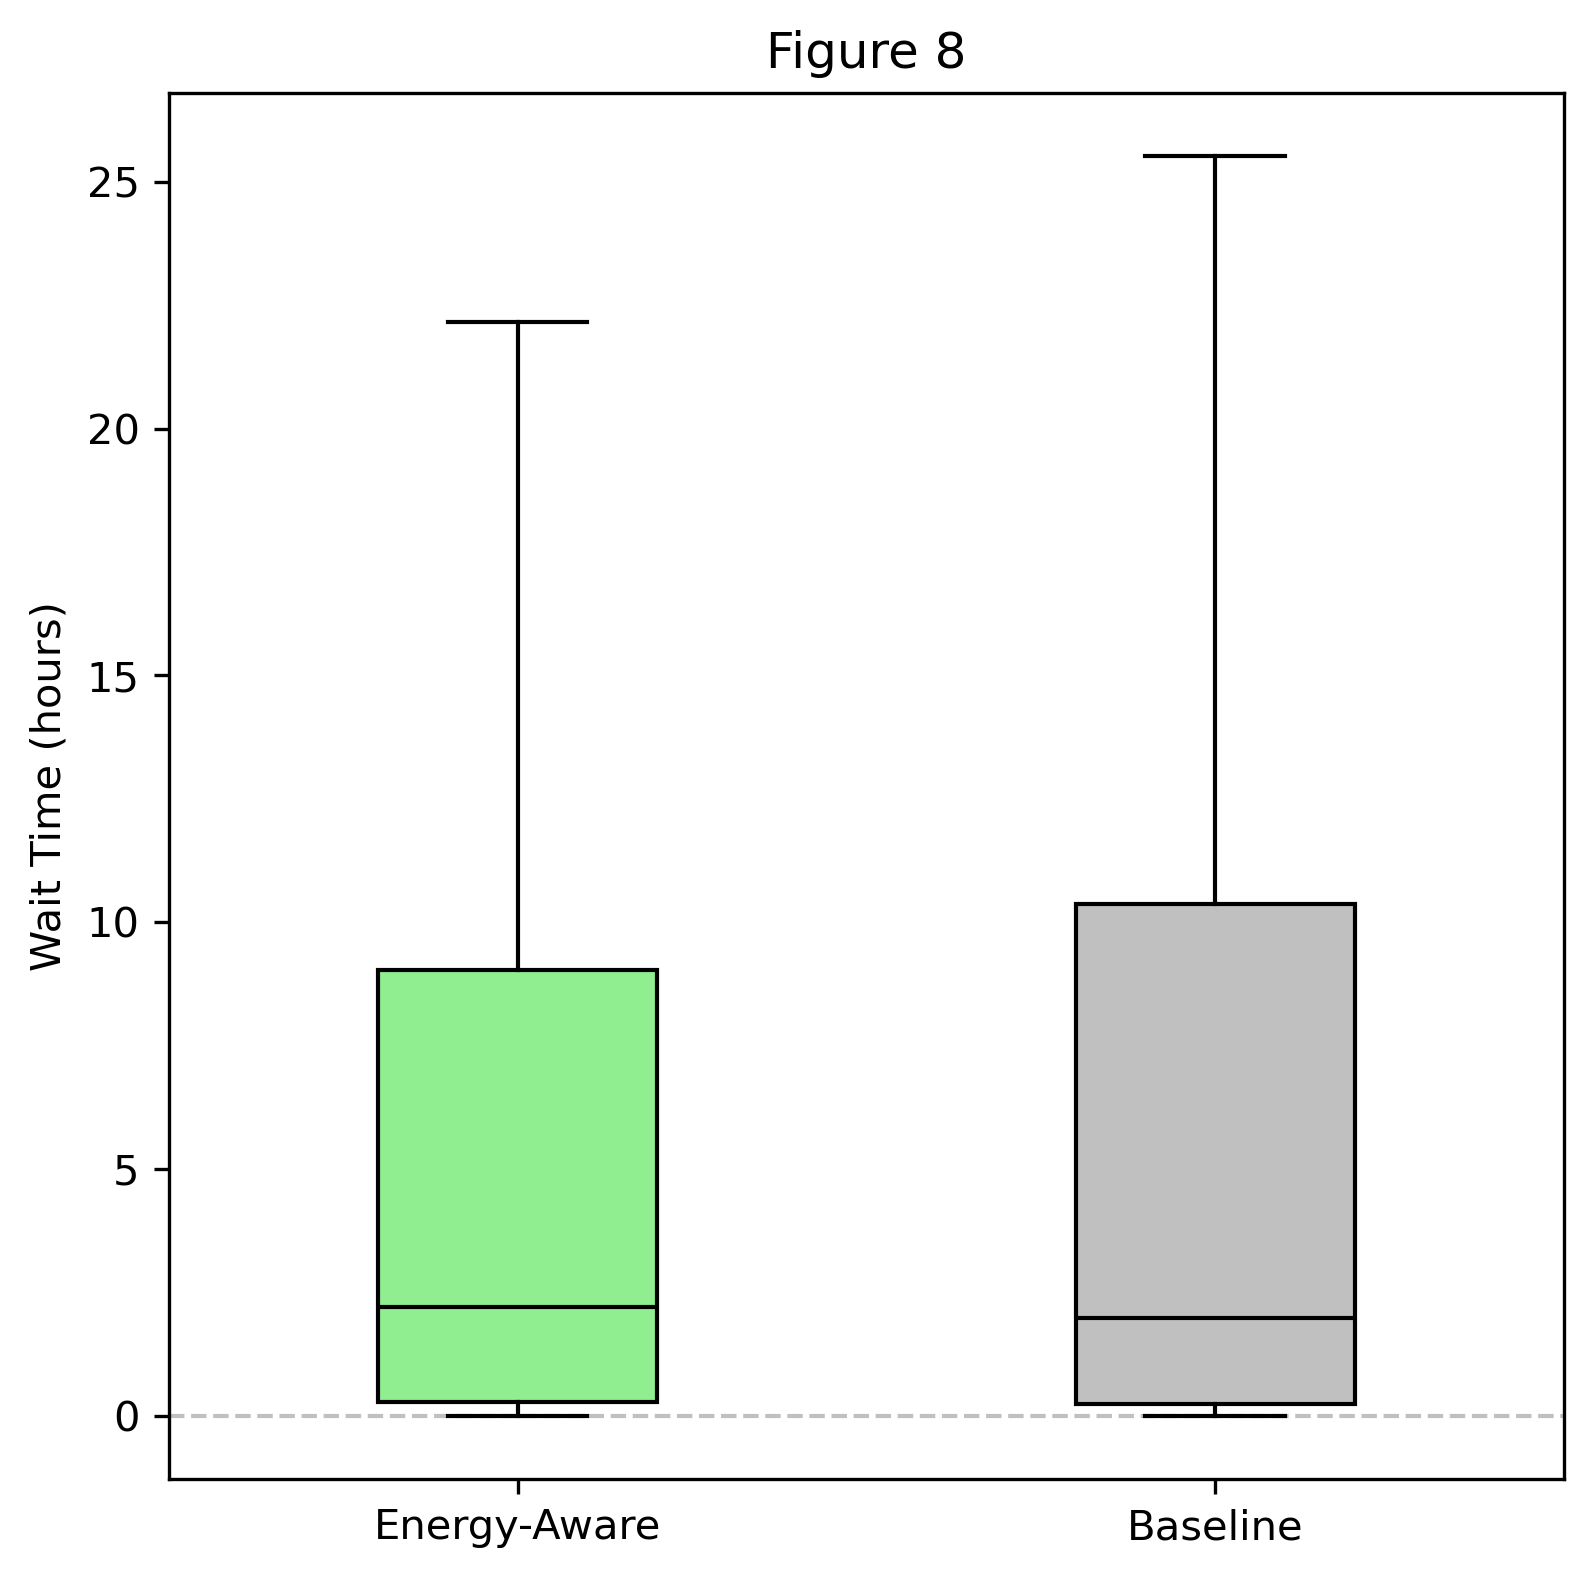

In [15]:
data = [ea_df['wait_time'] / 3600, 
        baseline_df['wait_time'] / 3600]

fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

box = ax.boxplot(data, patch_artist=True, showfliers=False, widths=0.4)

colors = ['lightgreen', 'silver']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
for median in box['medians']:
    median.set(color='black', linewidth=1)

ax.set_xticklabels(['Energy-Aware', 'Baseline'])

ax.set_title('Figure 8')
ax.set_xlabel('')
ax.set_ylabel('Wait Time (hours)')

plt.hlines(y=0,xmin=0.5,xmax=2.5,linewidth=1,linestyle='--',color='silver',zorder=0)
plt.show()

## Figure 9

In [16]:
def process_time_binned_stats(df, value_col):
    """
    Compute mean and median statistics of a specified column, binned by minute of day.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing a 'time_of_day' column (in minutes, 0–1440).
    value_col : str
        Name of the column for which to compute statistics.

    Returns
    -------
    pd.DataFrame
        DataFrame with one row per minute bin, containing:
        - 'time_bin': interval of the bin (1-minute wide)
        - 'mean': mean of `value_col` within the bin
        - 'median': median of `value_col` within the bin
        - 'bin_mid': midpoint of the bin (used for plotting or alignment)
    """
    bins = np.arange(0, 1441, 1)
    df['time_bin'] = pd.cut(df['time_of_day'], bins=bins, include_lowest=True, right=False)
    stats = df.groupby('time_bin')[value_col].agg(['mean', 'median']).reset_index()
    stats['bin_mid'] = stats['time_bin'].apply(lambda interval: interval.left + (interval.right - interval.left) / 2)
    return stats

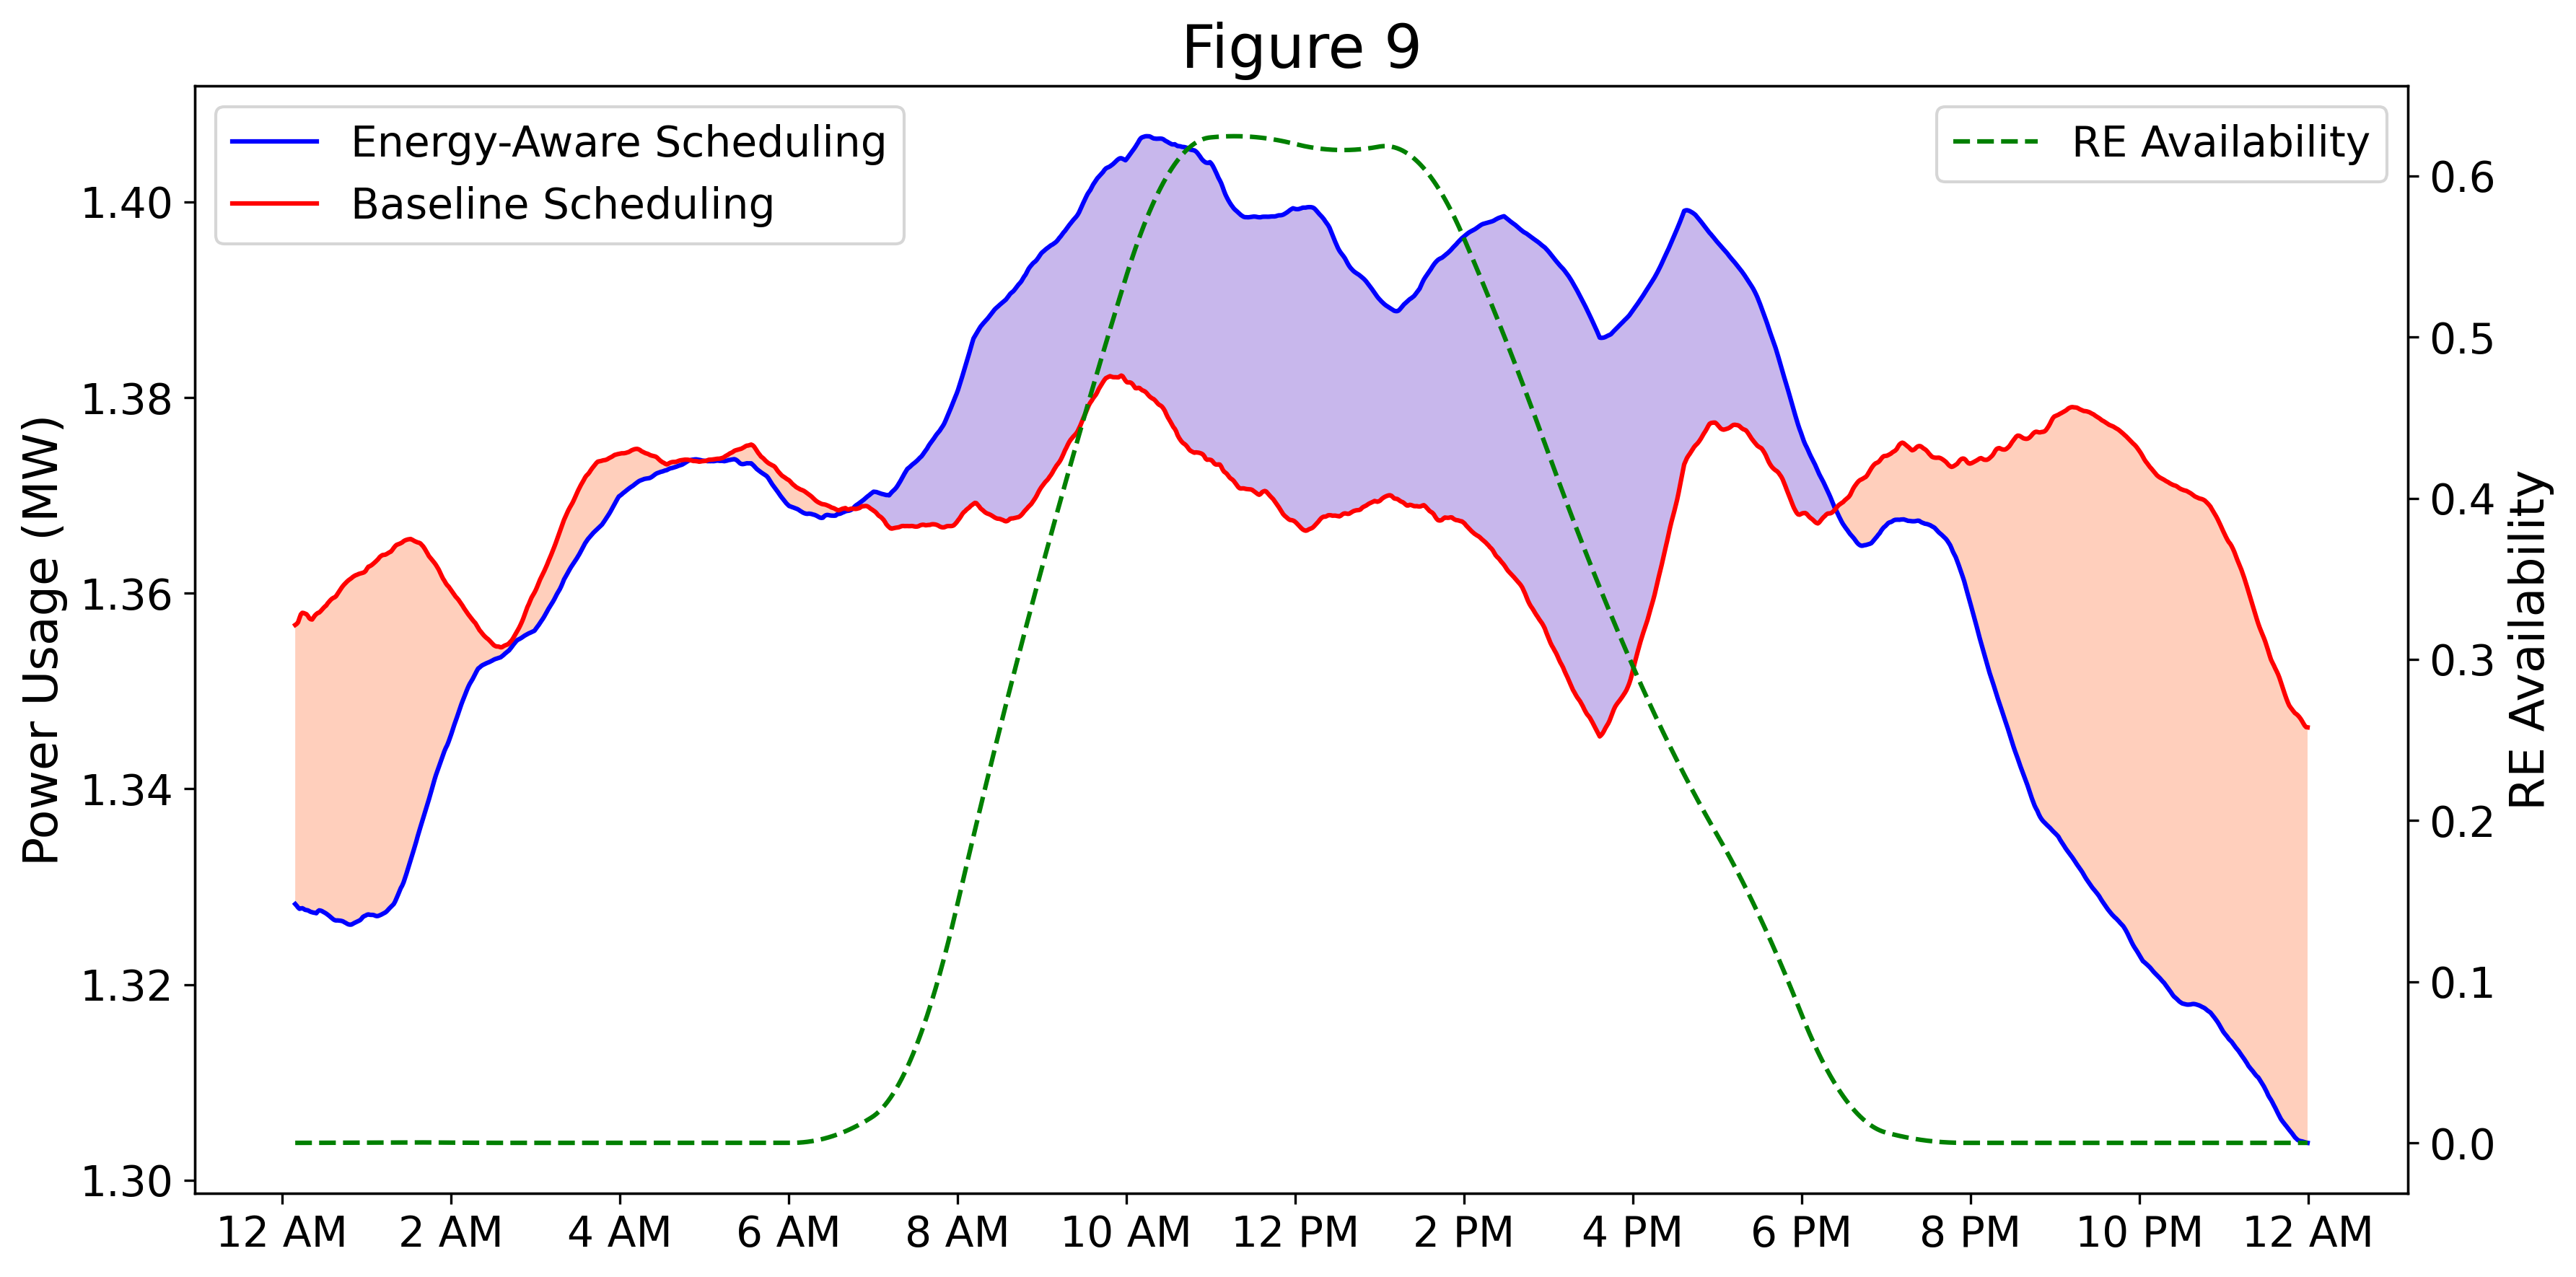

In [17]:
power_changes_baseline = compute_power_timeseries(baseline_df)
power_changes_ea = compute_power_timeseries(ea_df)

# Process data
ea_stats = process_time_binned_stats(power_changes_ea, 'allocated_power')
gt_stats = process_time_binned_stats(power_changes_baseline, 'allocated_power')

# Smooth the time series using a rolling mean (window=60)
sim_mean_smoothed = ea_stats['mean'].rolling(60, min_periods=10).mean()
gt_mean_smoothed = (gt_stats['mean'].rolling(60, min_periods=10).mean())

# Prepare the x-axis values
x = ea_stats['bin_mid']

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6), dpi=300)

# Plot the smoothed mean curves
ax1.plot(x, sim_mean_smoothed / 1e6, color='blue', label='Energy-Aware Scheduling')
ax1.plot(x, gt_mean_smoothed / 1e6, color='red', label='Baseline Scheduling')

# Fill between the curves:
#  - Blueish purple when ea_stats > gt_stats
#  - Light red when gt_stats > ea_stats
ax1.fill_between(x, sim_mean_smoothed / 1e6, gt_mean_smoothed / 1e6,
                 where=(sim_mean_smoothed >= gt_mean_smoothed),
                 interpolate=True,
                 facecolor='mediumpurple', alpha=0.5)
ax1.fill_between(x, sim_mean_smoothed / 1e6, gt_mean_smoothed / 1e6,
                 where=(gt_mean_smoothed > sim_mean_smoothed),
                 interpolate=True,
                 facecolor='lightsalmon', alpha=0.5)

hour_ticks = np.arange(0, 1441, 120)
ax1.set_xticks(hour_ticks)

# Format the ticks as HH AM/PM
def format_time(x, pos):
    hours = int(x) // 60
    return f"{hours % 12 or 12} {'AM' if hours < 12 or hours > 23 else 'PM'}"

ax1.xaxis.set_major_formatter(FuncFormatter(format_time))


ax1.set_ylabel('Power Usage (MW)', fontsize=16)
ax1.set_title('Figure 9', fontsize=20)
ax1.legend(loc='upper left', fontsize=14)

# Plot the RE Availability on the right y-axis
ax2 = ax1.twinx()
ax2.plot(re_stats['bin_mid'], re_stats['mean'].rolling(60, min_periods=10).mean(), 
         color='green', linestyle='--', label='RE Availability')
ax2.set_ylabel('RE Availability', fontsize=16)
ax2.legend(loc='upper right', fontsize=14)

ax1.tick_params(axis='both', labelsize=14)  # Adjust the 14 to your preferred size
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

# Optimization

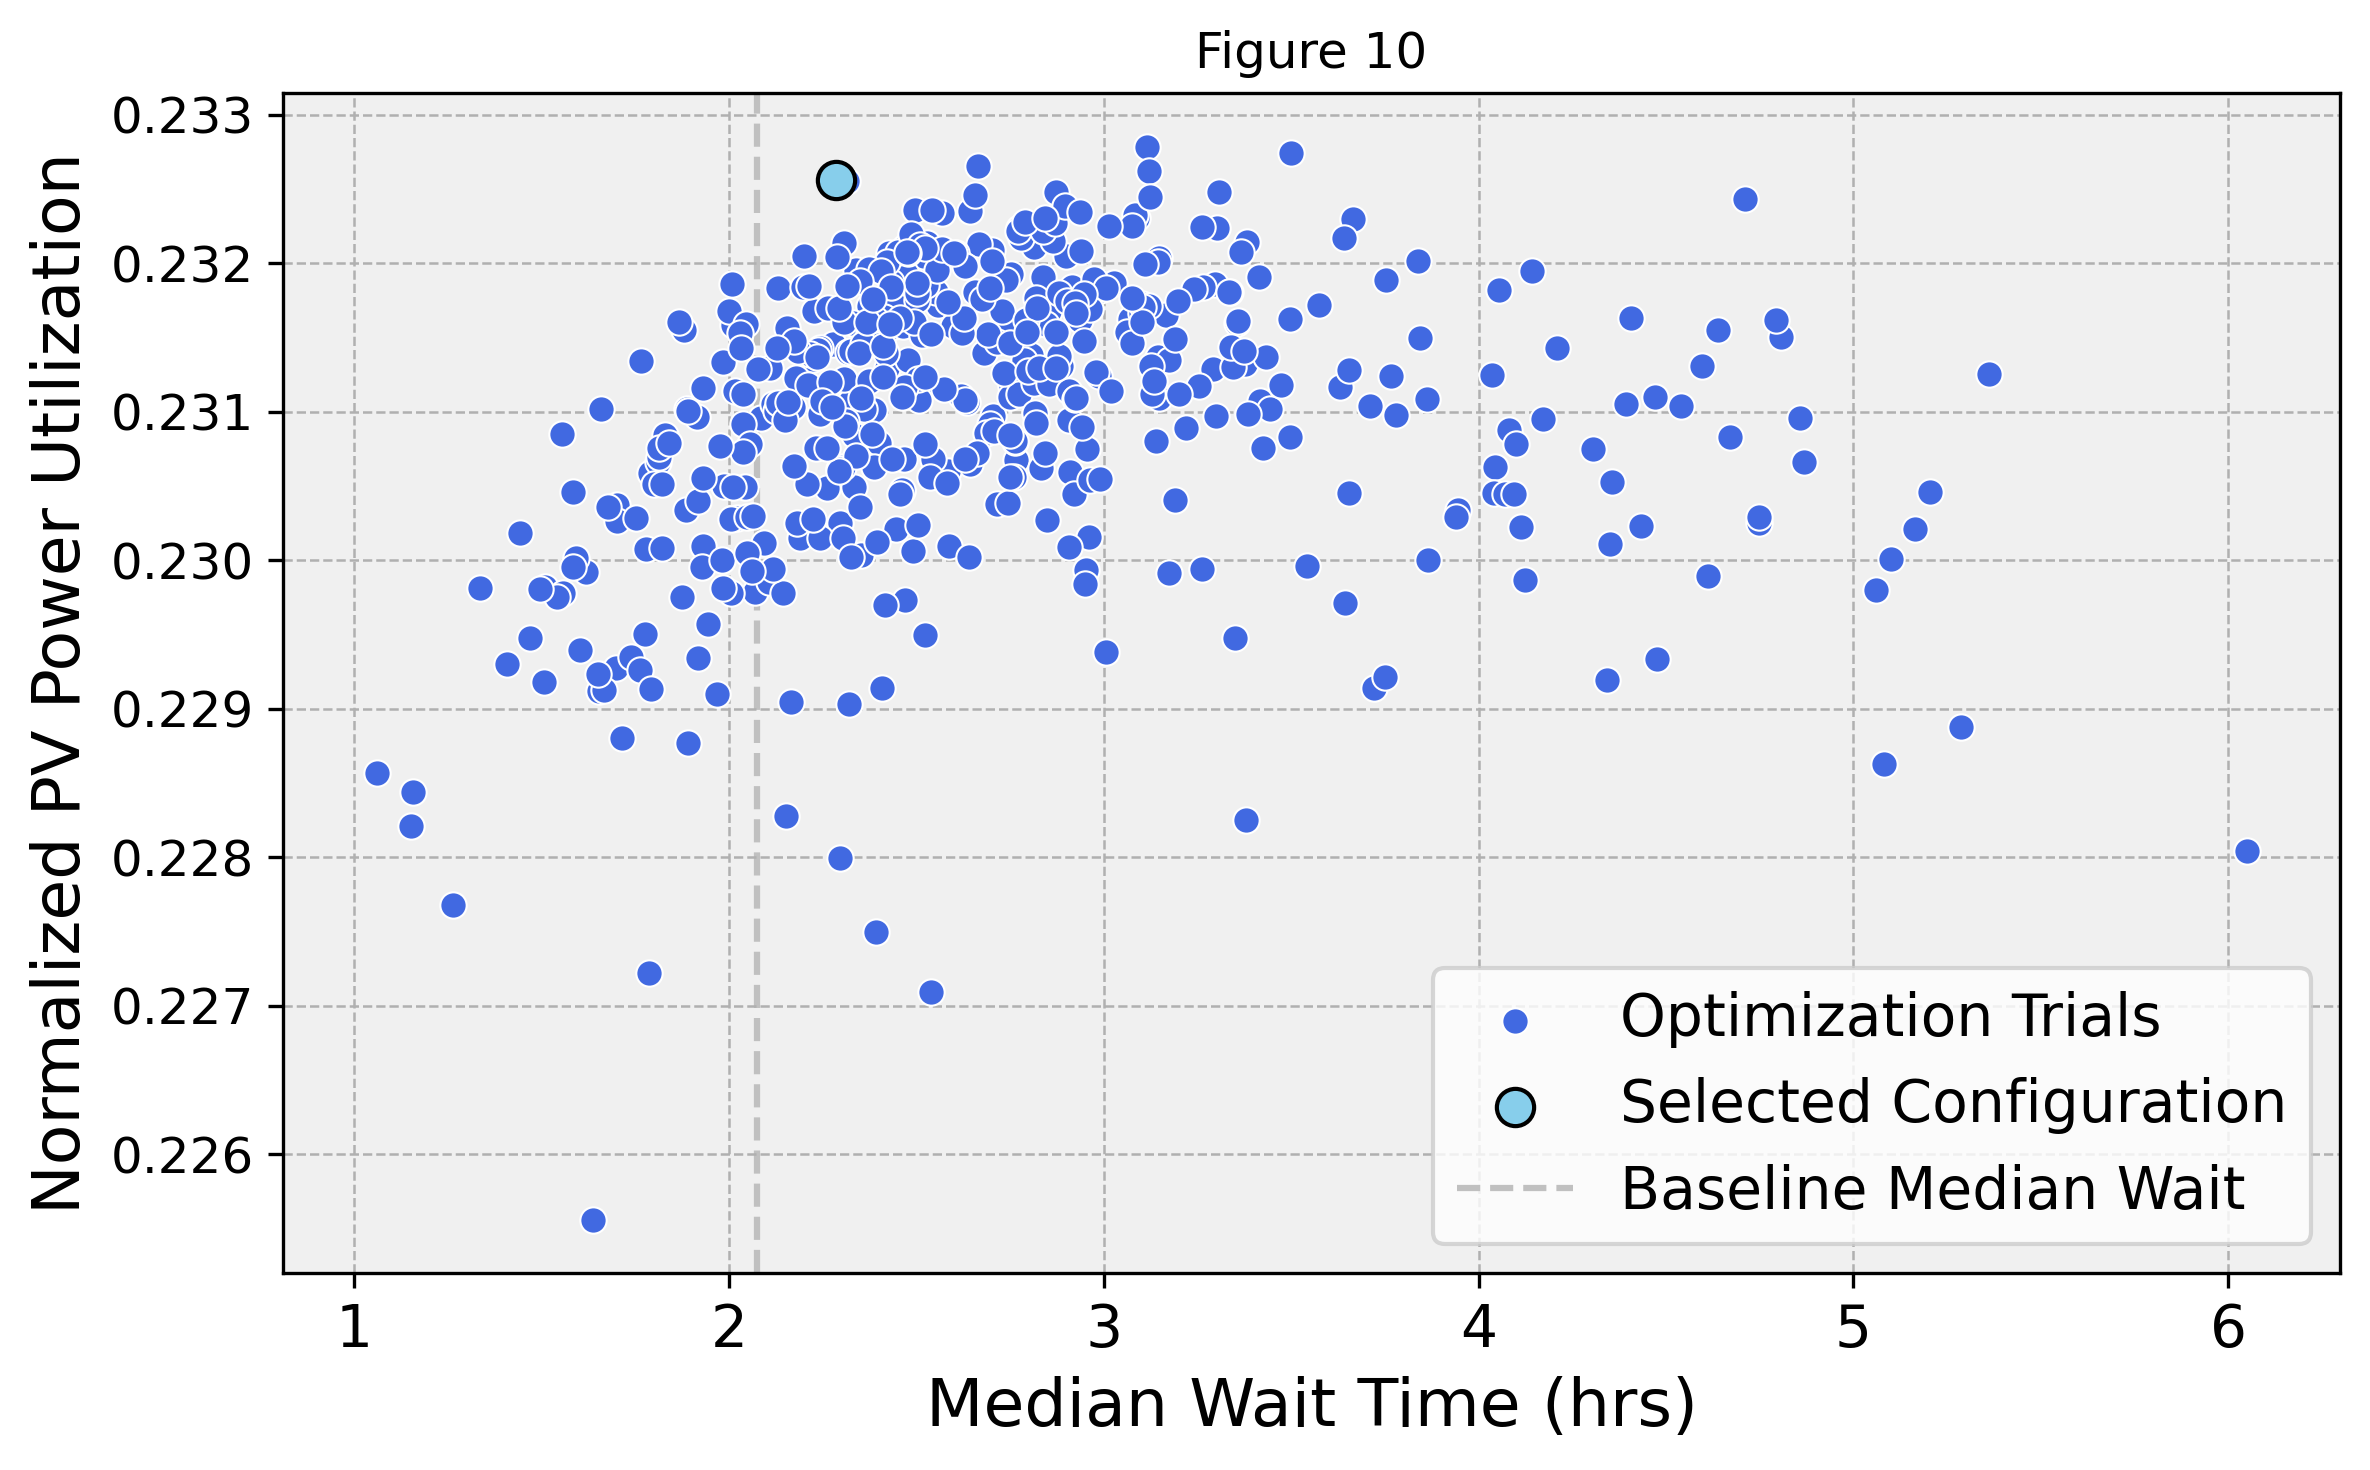

In [18]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.set_facecolor('#f0f0f0')              # Light grey axes background

plt.grid(True, linestyle='--', linewidth=.6, alpha=1.0, zorder=0)  # White grid

plt.scatter(
    optuna_results.median_wait_time,
    optuna_results.re_utilization,
    c='royalblue',
    alpha=1,
    s=40,
    edgecolors='white',
    linewidths=0.5,
    label='Optimization Trials'
)

# Highlighted point
plt.scatter(
    optuna_results.iloc[400].median_wait_time,
    optuna_results.iloc[400].re_utilization,
    c='skyblue',
    edgecolor='black',
    s=80,
    zorder=3,
    label='Selected Configuration'
)

# Reference line
plt.axvline(x=2.0746, ymin=0, ymax=1, color='silver', linestyle='--', linewidth=1.5, label='Baseline Median Wait', zorder=0)


ax.set_axisbelow(True)
plt.xlabel("Median Wait Time (hrs)", fontsize=16)
plt.ylabel("Normalized PV Power Utilization", fontsize=16)
plt.legend(frameon=True, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.title('Figure 10')
plt.tight_layout()
plt.show()

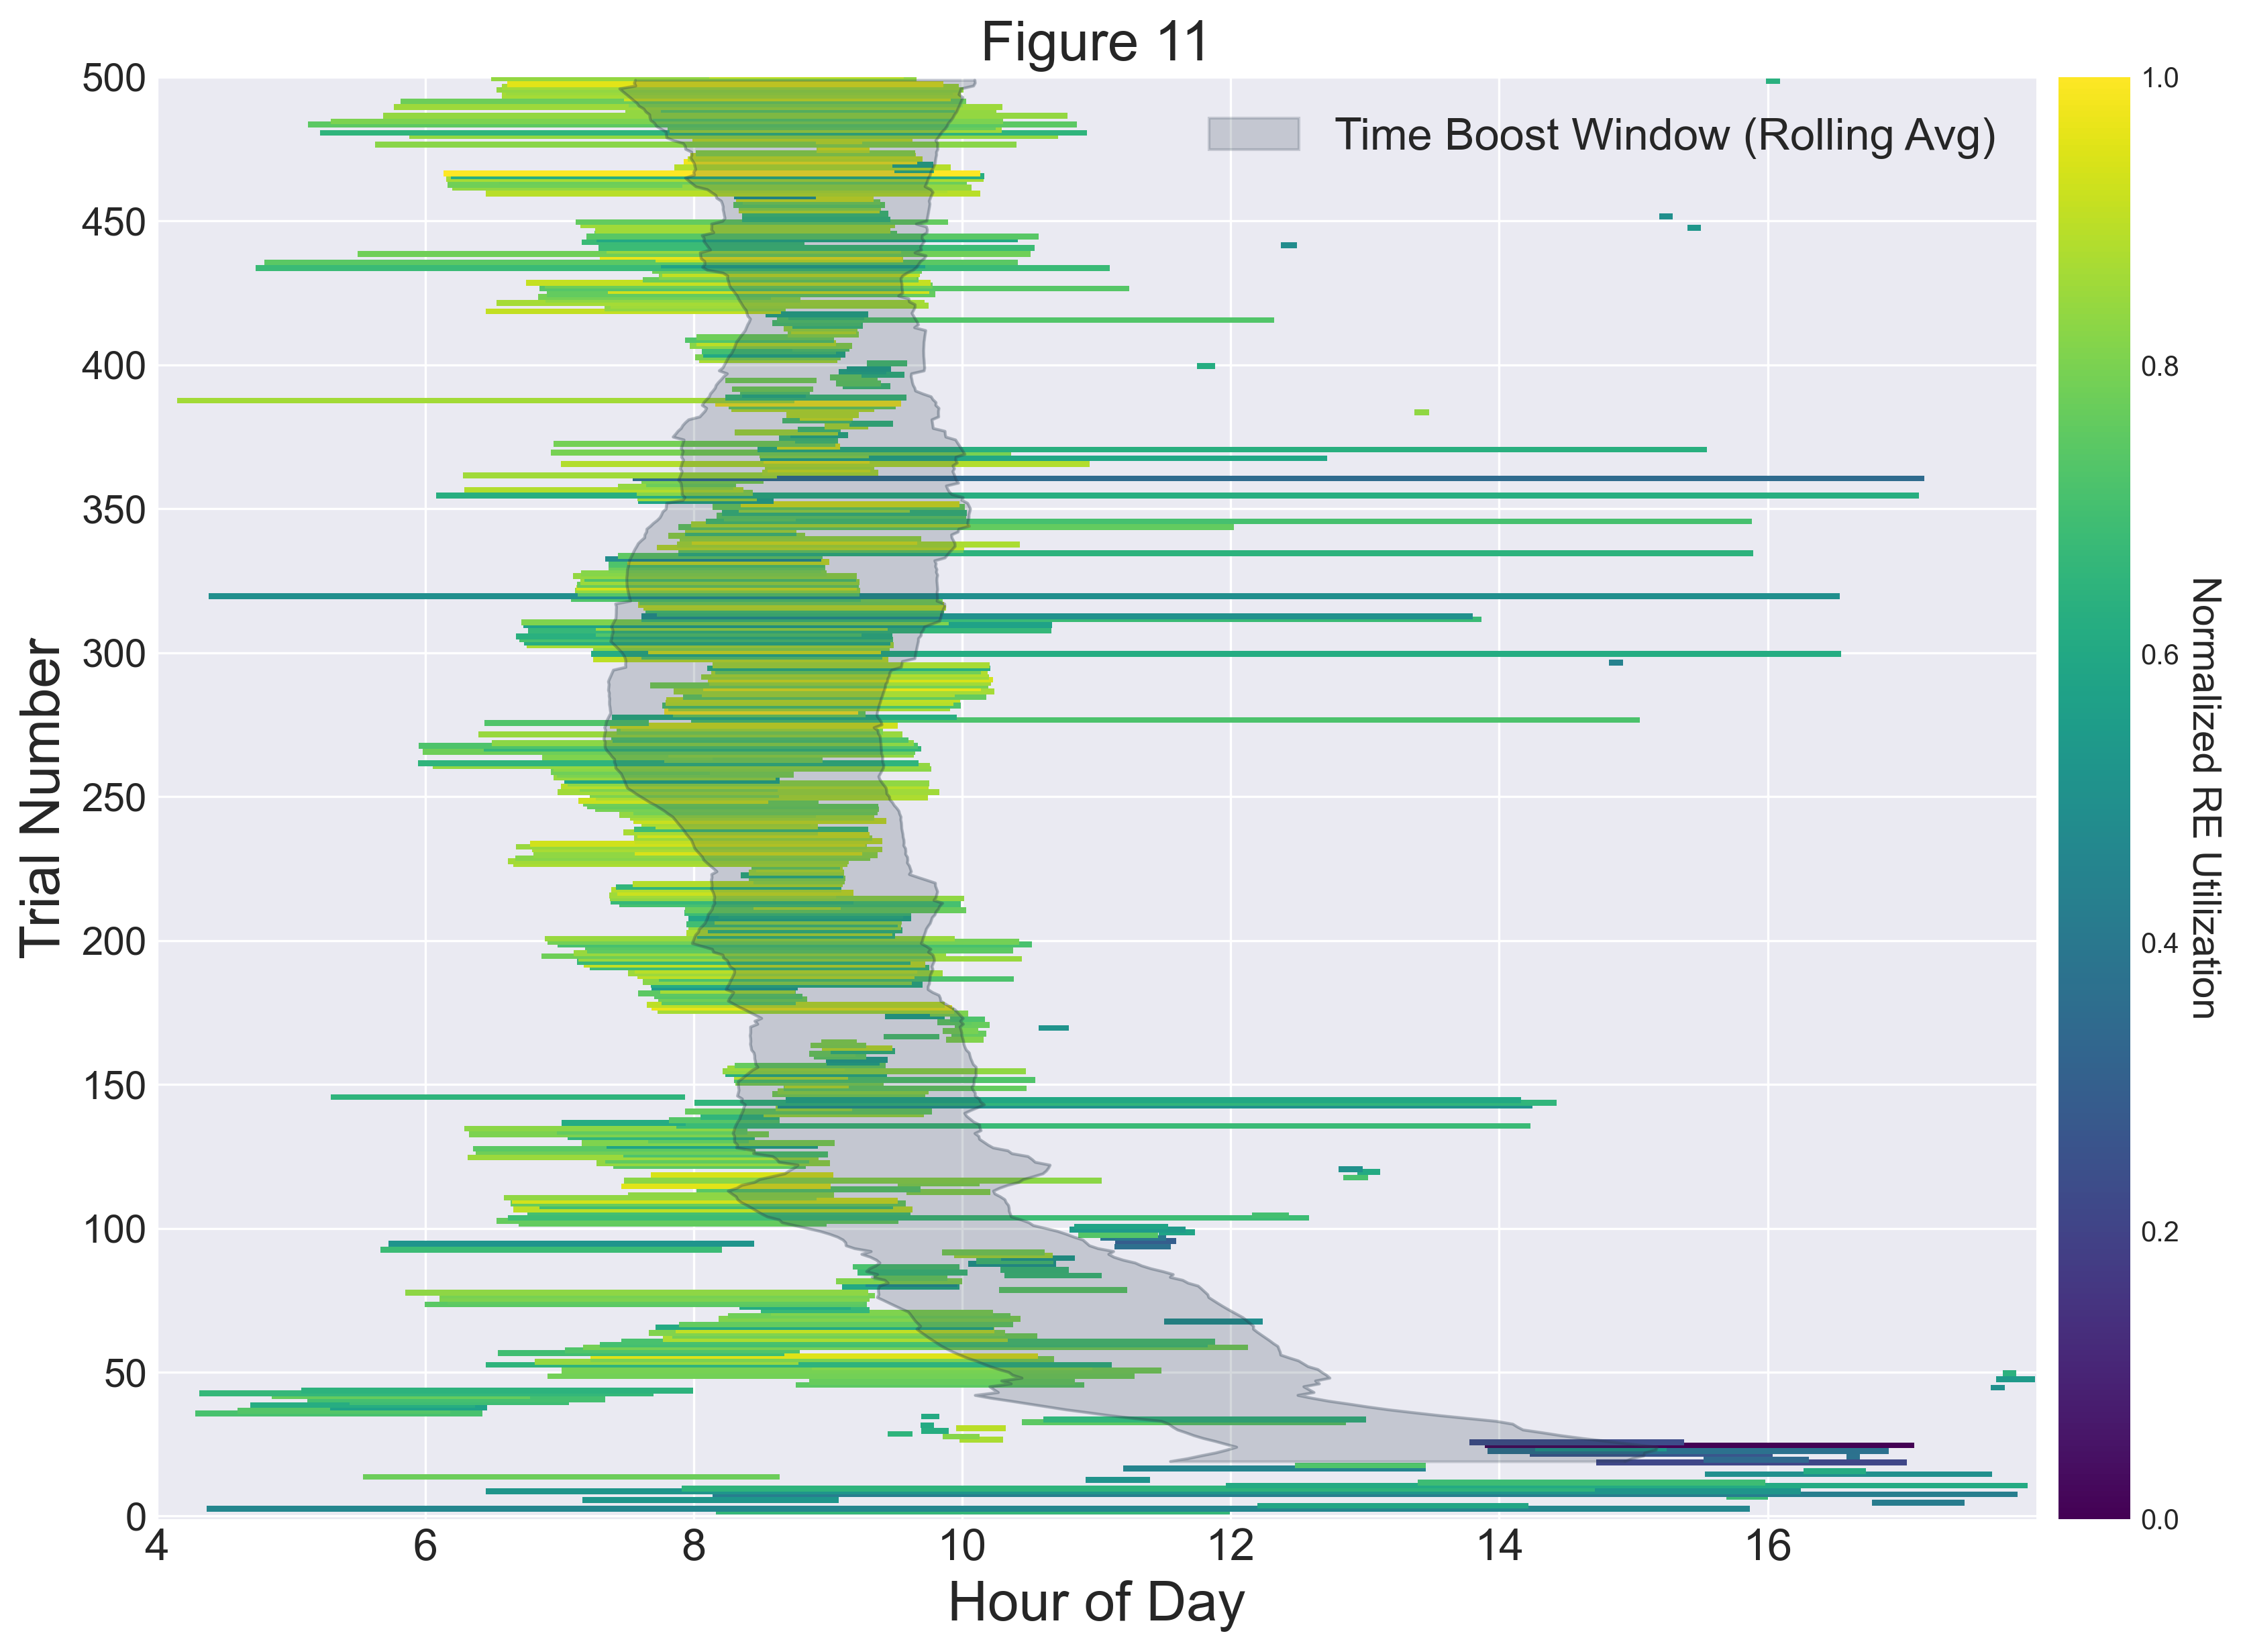

In [19]:
# Convert study trials to a pandas DataFrame.
df_trials = optuna_study.trials_dataframe()

# Remove trials without an objective value and sort by trial number.
df_trials = df_trials.dropna(subset=["value"])
df_trials.sort_values(by="number", inplace=True)

# Convert the time boost parameters to float.
df_trials["tbs"] = df_trials["params_time_boost_start"].astype(float)
df_trials["tbe"] = df_trials["params_time_boost_end"].astype(float)
df_trials["obj"] = ((df_trials["value"] - df_trials["value"].min()) /
                    (df_trials["value"].max() - df_trials["value"].min()))
df_trials["trial_num"] = df_trials["number"]

# Calculate rolling averages for tbs and tbe.
window = 80  # Adjust the window size if needed.
rolling_avg_tbs = df_trials["tbs"].rolling(window=window, min_periods=20).mean()
rolling_avg_tbe = df_trials["tbe"].rolling(window=window, min_periods=20).mean()

# Set up a colormap (using "viridis") and a normalization for objective values.
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=df_trials["obj"].min(), vmax=df_trials["obj"].max())

plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
ax.set_xlim(4, 18)
ax.set_ylim(df_trials["trial_num"].min() - 1, df_trials["trial_num"].max() + 1)
ax.set_xlabel("Hour of Day", fontsize=20)
ax.set_ylabel("Trial Number", fontsize=20)

fill_color = "#2C3E50"
alpha_fill = 0.2

# Plot the rolling average fill between the time boost start and end.
ax.fill_betweenx(df_trials["trial_num"],
                 rolling_avg_tbs,
                 rolling_avg_tbe,
                 color=fill_color,
                 alpha=alpha_fill,
                 label="Time Boost Window (Rolling Avg)",
                 zorder=100)

# Plot dashed lines along the rolling averages (both edges) with the same color.
ax.plot(rolling_avg_tbs, df_trials["trial_num"], color=fill_color,
        linewidth=1, alpha=alpha_fill, zorder=100)
ax.plot(rolling_avg_tbe, df_trials["trial_num"], color=fill_color,
        linewidth=1, alpha=alpha_fill, zorder=100)

# Plot each trial as a horizontal rectangle.
for _, row in df_trials.iterrows():
    trial_no = row["trial_num"] + 1
    tbs = row["tbs"]
    tbe = row["tbe"]
    obj_val = row["obj"]
    width = tbe - tbs  # Assumes tbe > tbs.
    color = cmap(norm(obj_val))
    
    # Create and add the rectangle
    
    rect = patches.Rectangle((tbs, trial_no - 0.4), width, 2,
                             linewidth=1, facecolor=color, alpha=1, zorder=2)
    ax.add_patch(rect)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.01)
cbar.set_label("Normalized RE Utilization", fontsize=14, labelpad=15, rotation=270)

ax.set_xticks(np.arange(4, 18, 2))
y_min, y_max = 0, 500
n_yticks = 11
ax.set_yticks(np.linspace(y_min, y_max, num=n_yticks, dtype=int))

plt.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.title('Figure 11', fontsize=20)
plt.show()